In [ ]:
# CONSTANTS
# JW uses the following convention: X-axis is short, origin at lower left

RATIO = 3/5 # field is 100 ft by 60 ft
X_size_yd = 60
Y_size_yd = 100
fh_background_size = (600,1000) # size of background image -> scale everything by 10 for plotting
PLOT_SCALE = 10

In [ ]:
# update this as needed
start_times_dict = {'Temple': '12:00:00',
                    'BostonCollege': '15:05:25', # verified
                    'Cornell': '14:00:00',
                    'Northwestern': '15:07:10', # verified
                    'Harvard': '15:06:30', # verified
                    'Brown': '12:09:05', # verified
                    'Dartmouth': '11:00:00',
                    'Villanova': '12:00:00',
                    'Drexel': '12:00:00',
                    'LIU': '12:09:30', # verified
                    'Delaware': '13:12:00', # verified
                    'Columbia': '15:09:00', # verified
                    'Quinnipiac': '13:00:00',
                    'Princeton': '16:00:00',
                    'Yale': '12:07:49'}

# Load data for testing

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# import gdrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
GPS_data = pd.read_csv("/content/drive/MyDrive/PennAthletics/Team_Internal/Data/Processed Data/GPS_Data_appended.csv", sep=",", index_col=0)
GPS_data.head(2)

,Excel Timestamp,Speed,Accel Z,Heart Rate,athlete,game,date,Timestamp,X_frac,Y_frac,Planar Accel,Rolling Avg Speed
0,44813.615449,2.182240,0.295216,8,A15,BostonCollege,99,2022-09-09 14:46:14.800,0.195103,0.727582,0.089309,2.182240
1,44813.615451,2.204462,0.703617,8,A15,BostonCollege,99,2022-09-09 14:46:15.000,0.194292,0.731782,1.062688,2.193351


# Data Transformations

For preprocessing

In [ ]:
# turn coordinates into scaled positions between 0 and 1 on field
def project_coords(orig_coords, lr, ll, ul, ur):
  x_axis = lr-ll # 1 by 2
  y_axis = ul-ll # 1 by 2
  from_origin = orig_coords-ll # n by 2
  transform = np.vstack([x_axis, y_axis]).T
  new_coords = np.linalg.inv(transform) @ from_origin.T # n by 2

  return new_coords.T

# test case
orig_coords = np.array([1,1]) # original point

lower_left = np.array([0.5, 0.5])
lower_right = np.array([1.5, 1.5])
upper_left = np.array([-0.5, 0.5])
upper_right = np.array([1.5, 0.5])

projection = project_coords(orig_coords, lower_left, lower_right, upper_left, upper_right)
assert(np.linalg.norm(projection-np.array([0.5,0])) == 0) # test
print(projection)

[0.5 0. ]


# Making a heatmap

Of player position. Sample actual position every second and create a 2-D gaussian probability distribution, then sum these together.

In [ ]:
# input normalized positions scaled 0 to 1
def position_distribution(long_size, xpos, ypos, pos_std):
  ratio = 3/5
  short_size = int(ratio*long_size)
  big_zeros = np.zeros((long_size, short_size))
  if xpos<0 or ypos<0:
    return big_zeros
  x,y = int(short_size*xpos), int(long_size*ypos)
  lim_x, lim_y = int(3*pos_std*short_size), int(3*pos_std*long_size)

  # limits
  left = max(0, x-lim_x)
  right = min(short_size, x+lim_x)
  top = max(0, y-lim_y)
  bottom = min(long_size, y+lim_y)

  small_x, small_y = np.meshgrid(range(left, right), range(top, bottom))
  dists = (((small_x-x)/ratio)**2+(small_y-y)**2).astype("float") # do we need the ellipse or should we stick with circle?
  vals = np.exp(-dists/2/(pos_std*long_size)**2)

  big_zeros[top:bottom, left:right] = vals

  # note the data is inverted, so plot with origin = "lower"

  return big_zeros

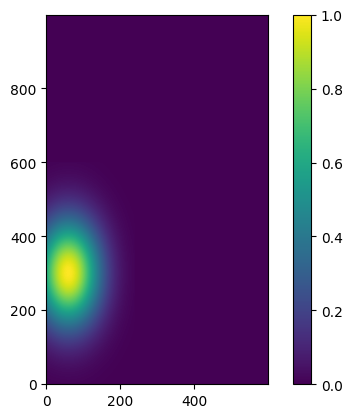

In [ ]:
# test a single distribution
test_values = position_distribution(1000, 0.1, 0.3, 0.1)
plt.imshow(test_values, origin="lower")
plt.colorbar()
plt.show()

In [ ]:
# using position_distribution(), create a heatmap
# data should contain only coordinates
# pos_std determines width of Gaussian
# size is the number of elements in each dimension
# skip is how many GPS data points per sample
def create_heatmap(data, pos_std=0.03, long_size=1000, skip=10):
  ratio = 3/5
  short_size = int(ratio*long_size)
  player_heatmap = np.zeros((long_size, short_size)).astype("float")
  nums_samp = data.shape[0]//skip
  x_positions =  data.iloc[:,0]
  y_positions = data.iloc[:,1]

  for i in range(nums_samp):
    player_heatmap += position_distribution(long_size, x_positions.iloc[skip*i], y_positions.iloc[skip*i], pos_std)

  return player_heatmap

# Overlay figure on field

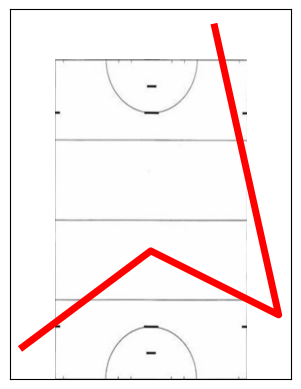

In [ ]:
# import img, imshow with proper scaled labels
def create_background(height=8, ratio=3/5, scale=10, show_axis=False):
  field_img = plt.imread("/content/drive/MyDrive/PennAthletics/Team_Internal/Data/cropped_fh.jpg")
  height = 8
  width = ratio*height
  y_size, x_size, _ = field_img.shape
  plt.figure(figsize=(height, width))
  plt.imshow(field_img, origin="lower")

  if show_axis:
    plt.xticks(ticks=np.linspace(0,x_size,4), labels=np.linspace(0,x_size/scale,4).astype("int"))
    plt.yticks(ticks=np.linspace(0,y_size,6), labels=np.linspace(0,y_size/scale,6).astype("int"))

  else:
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])

  return scale

# example usage/test case
scale = create_background()
field_x = np.array([-10,30,70,50])
field_y = np.array([10,40,20,110])
plt.plot(scale*field_x, scale*field_y, "r-", lw=5)
plt.show()

# Collecting specific data

In [ ]:
# grab the data from a past amount of time given a player and the time
# options is an iterable that could include: "CSV", "scatter", "heatmap"
def gather_data(data, timestamp, players=None, time_before=60, options=None):
  # default - get all players
  if players is None:
    players = data["athlete"].unique()

  # filter data
    filtered_data = data.query("athlete in @players").reset_index(drop=True)

    end_index = (filtered_data[filtered_data["Timestamp"] == timestamp]).index
    end_index = np.array(end_index)

  # get relevant data
  time_step = 0.1
  num_records = np.min([end_index.min(), int(time_before/time_step)])
  start_index = end_index-num_records+1 # either 0 or the end-num for each value

  # loop through and append to one dataframe
  datasets = []
  for i in range(len(start_index)):
    data = filtered_data.iloc[start_index[i]:end_index[i]+1]
    datasets.append(data)

  final_data = pd.concat(datasets)

  # produce outputs
  if options:
    if "scatter" in options:
      scale = create_background()
      for player in final_data["athlete"].unique():
        player_data = final_data.query("athlete == @player")
        plt.scatter(scale*X_size_yd*player_data["X_frac"],
                    scale*Y_size_yd*player_data["Y_frac"],
                    c=np.linspace(0,1,player_data.index.size),
                    cmap="Blues",
                    s=0.1)
      plt.show()
    if "CSV" in options:
      folder = "/content/drive/MyDrive/PennAthletics/Team_Internal/Data/Processed Data/"
      final_data.to_csv(folder+f"{game} for {time_before} seconds before {timestamp}.csv")
    if "heatmap" in options:
      positions = create_heatmap(final_data[["X_frac", "Y_frac"]], skip=1)
      plt.imshow(positions, origin="lower", cmap="gray")
      plt.show()

  return final_data

## Load specific events

Notes:

Outletting allows for penn to counterattack.

COEF = 1. means good for penn, -1. means bad.

There are 147 unlabeled events - drop?

Seq is the game index. Not important.

In [ ]:
def create_timestamp(frame):
  game_date, start_time, game_time = frame[["Date", "Time", "time_game"]].values
  d = datetime.strptime(game_date, '%B %d')
  x = datetime.strptime(start_time, '%H:%M:%S')+timedelta(seconds=round(game_time,1))
  return '2022' + d.strftime('-%m-%d') + ' ' + x.strftime('%H:%M:%S.%f')[:-3]

In [ ]:
events = pd.read_csv("/content/drive/MyDrive/PennAthletics/data/FH event data XML files /FH_events_2022_season.csv", sep=",")
events.rename(columns={"t_quater":"t_quarter"}, inplace=True)
events["category"] = events["category"].replace({'oponent':'opponent'})
events.head(2)

,code,OP,ID,start,end,time_game,is_OT_game,time_Q1,time_Q2,time_Q3,...,Date,Time,At,W_L,Result,code_2,category,COEF,time_win_quarter,t_quarter
0,25 Entry,Temple,152,3304.650000,3319.650000,3287.13,OT,NaN,NaN,365.14,...,September 25,12:00:00,Away,W,2-0,P 25 Entry,penn,1.0,365.14,Q3
1,25 Entry,BostonCollege,158,3599.088667,3619.088667,3607.50,OT,NaN,NaN,940.72,...,September 9,15:00:00,Home,L,1-2 SO,P 25 Entry,penn,1.0,940.72,Q3


In [ ]:
events.query("At == 'Home'").groupby("OP")["Result"].unique()

OP
BostonCollege    [1-2 SO]
Brown               [3-2]
Columbia            [7-2]
Delaware            [4-1]
Harvard             [1-2]
LIU                 [2-0]
Northwestern        [3-4]
Villanova        [1-2 OT]
Name: Result, dtype: object

In [ ]:
GPS_data["game"].unique()

array(['BostonCollege', 'Brown', 'Columbia', 'Delaware', 'Harvard', 'LIU',
       'Northwestern', 'Temple', 'Yale'], dtype=object)

In [ ]:
event_dict= pd.read_csv("/content/drive/MyDrive/PennAthletics/data/FH event data XML files /FH event codes.csv", sep=",")
event_dict.head()

,code_raw,code_2,category,description
0,O 25 Entry,O 25 Entry,oponent,Opponent enters our defensive 25
1,25 Entry,P 25 Entry,penn,Penn enters our attacking 25
2,O Circle Pen,O Circle Pen,oponent,Opponent enters our circle
3,Circle Pen,P Circle Pen,penn,Penn enters our attacking circle
4,O Earn PC,O Earn PC,oponent,"Opponent wins a penalty corner, draws a foul (..."


In [ ]:
events_joined = events.copy()
# convert to appropriate start time
events_joined["Time"] = list(map(lambda x: start_times_dict[x], events["OP"]))

# turn times into a stamp like '2022-10-15 11:32:01.700'
events_joined["Timestamp"] = events_joined.aggregate(func=create_timestamp, axis=1)

# map event names
mapping = event_dict.set_index("code_2")["description"]
events_joined["event_name"] = events_joined["code_2"].map(mapping)

# drop extra data
drop_cols = ["code", "start", "end", "time_Q1", "time_Q2", "time_Q3", "time_OT", "time_Q4", "ID", "Date", "Time", "time_game", "is_OT_game", "seq"]
events_joined.drop(columns=drop_cols, inplace=True)
events_joined.dropna(inplace=True)
print(events_joined.shape)

events_joined.query("OP == 'Northwestern'").head(2)

(4205, 11)


,OP,At,W_L,Result,code_2,category,COEF,time_win_quarter,t_quarter,Timestamp,event_name
3,Northwestern,Home,L,3-4,P 25 Entry,penn,1.0,563.36,Q3,2022-09-16 16:14:08.300,Penn enters our attacking 25
39,Northwestern,Home,L,3-4,P 25 Entry,penn,1.0,1381.77,Q2,2022-09-16 15:51:11.500,Penn enters our attacking 25


Algorithm for matching timestamps.

1) In the GPS data, find the latest time when all players are still and line up in the starting positions. This corresponds to the start of the game. Watch the Box video to find the video time of game start. This allows us to find the time the video began.

2) Use the event data to find the event timestamp of the first goal.

3) Scroll around that area in the video to find when that happens.

4) Calculate the timestamp that corresponds with time 0 in the event data. The actual time of the first goal equals (Video time of goal) - (Video time of game start) + (Actual time of game start). Use the difference between this and the time shown in the event data to update the start time of recording of the event data.

5) Verify these times align properly.

In [ ]:
events.iloc[1062]

code                        Goal
OP                  Northwestern
ID                           211
start                    4530.05
end                      4547.05
time_game                4534.82
is_OT_game                    OT
time_Q1                      NaN
time_Q2                      NaN
time_Q3                  1059.88
time_OT                      NaN
time_Q4                      NaN
seq                            5
Date                September 16
Time                    15:00:00
At                          Home
W_L                            L
Result                       3-4
code_2                    P Goal
category                    penn
COEF                         1.0
time_win_quarter         1059.88
t_quarter                     Q3
Name: 1062, dtype: object

In [ ]:
# test a chosen event stamp
stamp = '2022-09-16 15:07:15.000'
print(stamp)
test_data = gather_data(GPS_data, stamp, players=None, time_before=10, options=["scatter"])

Northwestern

Actual time of game start: 15:07:15

Video time of game start: 6:05

Event data time of goal: 15:32:45

Video time of goal: 00:38:45

Video start time: 15:01:10

Actual time of goal: 15:39:55

Event start time: 15:07:10


2022-09-16 15:52:08.700


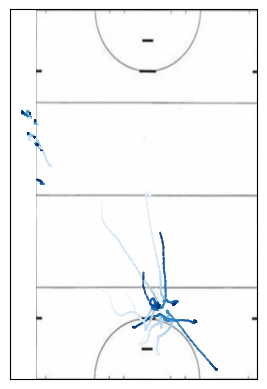

2022-09-16 16:22:24.800


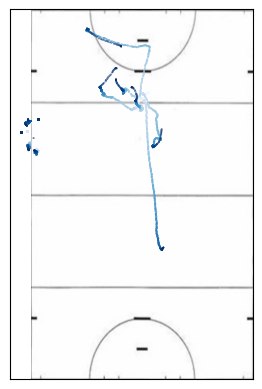

2022-09-16 15:39:37.600


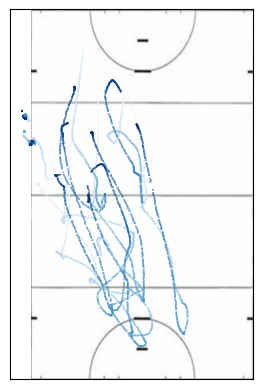

In [ ]:
# test an actual event stamp
goal_event = 'Penn goal – captures 12 seconds before the goal and 4 seconds after'
goals = events_joined.query("event_name == @goal_event")
for i in range(3):
  stamp = goals[goals["OP"] == "Northwestern"]["Timestamp"].iloc[i]
  print(stamp)
  test_data = gather_data(GPS_data, stamp, players=None, time_before=40, options=["scatter"])

In [ ]:
all_goals_map = np.zeros([1000, 600])
for opp, time in goals[["OP", "Timestamp"]].values:
  try:
    this_data = gather_data(GPS_data, time, opp)
    all_goals_map += create_heatmap(this_data[["X frac", "Y frac"]], pos_std=0.03, long_size=1000, skip=10)
  except:
    KeyError

plt.imshow(all_goals_map)
plt.show()